In [6]:
import cv2
import pandas as pd
import easyocr
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
import time

In [3]:
# Initialize YOLO model
model = YOLO("/Users/daksh/Desktop/ANPR/runs/detect/train/weights/best.pt")  # Replace with your trained model path

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)

# Define CSV output file path
output_csv_path = Path("/Users/daksh/Desktop/ANPR/output/vehicle_numbers.csv")

# Create or open CSV file
if not output_csv_path.exists():
    df = pd.DataFrame(columns=["Frame", "Vehicle_Number"])
    df.to_csv(output_csv_path, index=False)
else:
    df = pd.read_csv(output_csv_path)

# Video path
video_path = "/Users/daksh/Desktop/ANPR/assets/vid.mp4"
cap = cv2.VideoCapture(video_path)

# Variables for optimizations
frame_rate = 5  # Process 1 frame every 5 frames (adjust based on performance)
frame_count = 0

def preprocess_frame(frame):
    """Preprocess frame for variable lighting conditions (brightness/contrast)."""
    return cv2.convertScaleAbs(frame, alpha=1.5, beta=30)

def detect_and_extract(frame, frame_number):
    """Detect license plates and extract vehicle numbers."""
    # Detect objects using YOLO
    results = model(frame)
    plates = []
    
    for result in results[0].boxes.data:
        confidence = result[4]
        if confidence > 0.5:  # Filter with confidence threshold
            x1, y1, x2, y2 = result[:4].int().tolist()
            cropped_plate = frame[y1:y2, x1:x2]
            try:
                # Use EasyOCR to extract text from cropped license plate
                ocr_result = reader.readtext(cropped_plate)
                for bbox, text, conf in ocr_result:
                    plates.append((frame_number, text.strip()))
                    print(f"Frame {frame_number}: Detected number: {text.strip()}")
            except Exception as e:
                print(f"Error during OCR: {e}")
    
    return plates

# Process video
start_time = time.time()
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Process every nth frame to optimize performance
    if frame_count % frame_rate == 0:
        frame = preprocess_frame(frame)
        detected_plates = detect_and_extract(frame, frame_count)
        
        # Append detected numbers to CSV
        if detected_plates:
            for plate in detected_plates:
                df = pd.concat([df, pd.DataFrame([plate], columns=["Frame", "Vehicle_Number"])], ignore_index=True)
            df.to_csv(output_csv_path, index=False)

    # Display frame (optional)
    cv2.imshow("Frame", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Final save to CSV
df.to_csv(output_csv_path, index=False)

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds.")


0: 288x480 2 car-licence-plates, 68.0ms
Speed: 3.1ms preprocess, 68.0ms inference, 1.1ms postprocess per image at shape (1, 3, 288, 480)
Frame 5: Detected number: Nai] NpU
Frame 5: Detected number: LSINSUT



2024-10-05 12:02:45.093 python[79913:648812] +[IMKClient subclass]: chose IMKClient_Legacy
2024-10-05 12:02:45.093 python[79913:648812] +[IMKInputSession subclass]: chose IMKInputSession_Legacy


0: 288x480 2 car-licence-plates, 39.5ms
Speed: 1.3ms preprocess, 39.5ms inference, 0.8ms postprocess per image at shape (1, 3, 288, 480)
Frame 10: Detected number: Naij NRU

0: 288x480 2 car-licence-plates, 56.0ms
Speed: 1.5ms preprocess, 56.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 480)
Frame 15: Detected number: Naij NRU

0: 288x480 2 car-licence-plates, 38.2ms
Speed: 1.0ms preprocess, 38.2ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 480)
Frame 20: Detected number: NaIJ NRU

0: 288x480 2 car-licence-plates, 35.0ms
Speed: 1.1ms preprocess, 35.0ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 480)
Frame 25: Detected number: NAIJ NRU

0: 288x480 2 car-licence-plates, 34.6ms
Speed: 1.1ms preprocess, 34.6ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 480)
Frame 30: Detected number: Nai] NRu
Frame 30: Detected number: HJSISU

0: 288x480 1 car-licence-plate, 37.3ms
Speed: 1.1ms preprocess, 37.3ms inference, 0.7ms postproc

In [4]:
# Initialize YOLO model
model = YOLO("/Users/daksh/Desktop/ANPR/runs/detect/train/weights/best.pt")

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'], gpu=True)

# Define CSV output file path
output_csv_path = Path("/Users/daksh/Desktop/ANPR/output/vehicle_numbers.csv")

# Video path
video_path = "/Users/daksh/Desktop/ANPR/assets/vid.mp4"

# Create or open CSV file
if not output_csv_path.exists():
    df = pd.DataFrame(columns=["Frame", "Vehicle_Number"])
    df.to_csv(output_csv_path, index=False)
else:
    df = pd.read_csv(output_csv_path)


cap = cv2.VideoCapture(video_path)

# Variables for optimizations
frame_rate = 5  # Process 1 frame every 5 frames (adjust based on performance)
frame_count = 0
recent_plates = {}  # To store recently detected plates and their frame numbers

def preprocess_frame(frame):
    """Preprocess frame for variable lighting conditions (brightness/contrast)."""
    return cv2.convertScaleAbs(frame, alpha=1.5, beta=30)

def detect_and_extract(frame, frame_number):
    """Detect license plates and extract vehicle numbers."""
    results = model(frame)
    plates = []
    
    for result in results[0].boxes.data:
        confidence = result[4]
        if confidence > 0.5:  # Filter with confidence threshold
            x1, y1, x2, y2 = result[:4].int().tolist()
            cropped_plate = frame[y1:y2, x1:x2]

            try:
                # Use EasyOCR to extract text from cropped license plate
                ocr_result = reader.readtext(cropped_plate)
                for bbox, text, conf in ocr_result:
                    detected_plate = text.strip()
                    # Ensure the detected plate is not added repeatedly within 30 frames
                    if detected_plate not in recent_plates or (frame_number - recent_plates[detected_plate]) > 50:
                        plates.append((frame_number, detected_plate))
                        recent_plates[detected_plate] = frame_number
                        # Draw the bounding box and the extracted number on the frame
                        cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                        cv2.putText(frame, detected_plate, (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
                        print(f"Frame {frame_number}: Detected number: {detected_plate}")
            except Exception as e:
                print(f"Error during OCR: {e}")
    
    return plates

# Process video
start_time = time.time()
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Process every nth frame to optimize performance
    if frame_count % frame_rate == 0:
        frame = preprocess_frame(frame)
        detected_plates = detect_and_extract(frame, frame_count)
        
        # Append detected numbers to CSV
        if detected_plates:
            for plate in detected_plates:
                df = pd.concat([df, pd.DataFrame([plate], columns=["Frame", "Vehicle_Number"])], ignore_index=True)
            df.to_csv(output_csv_path, index=False)

    # Display the frame with bounding boxes and text
    cv2.imshow("ANPR Processing", frame)
    
    # Press 'q' to exit the video display
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# Final save to CSV
df.to_csv(output_csv_path, index=False)

end_time = time.time()
print(f"Processing completed in {end_time - start_time:.2f} seconds.")


0: 288x480 2 car-licence-plates, 52.6ms
Speed: 1.3ms preprocess, 52.6ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 480)
Frame 5: Detected number: Nai] NpU
Frame 5: Detected number: LSINSUT

0: 288x480 2 car-licence-plates, 55.4ms
Speed: 1.1ms preprocess, 55.4ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 480)
Frame 10: Detected number: Naij NRU

0: 288x480 2 car-licence-plates, 47.5ms
Speed: 1.3ms preprocess, 47.5ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 480)

0: 288x480 2 car-licence-plates, 39.7ms
Speed: 1.1ms preprocess, 39.7ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 480)
Frame 20: Detected number: NaIJ NRU

0: 288x480 2 car-licence-plates, 42.2ms
Speed: 0.9ms preprocess, 42.2ms inference, 0.9ms postprocess per image at shape (1, 3, 288, 480)
Frame 25: Detected number: NAIJ NRU

0: 288x480 2 car-licence-plates, 40.9ms
Speed: 1.1ms preprocess, 40.9ms inference, 0.7ms postprocess per image at shape (1, 3, 288, 


0: 416x480 1 car-licence-plate, 64.7ms
Speed: 1.6ms preprocess, 64.7ms inference, 0.5ms postprocess per image at shape (1, 3, 416, 480)


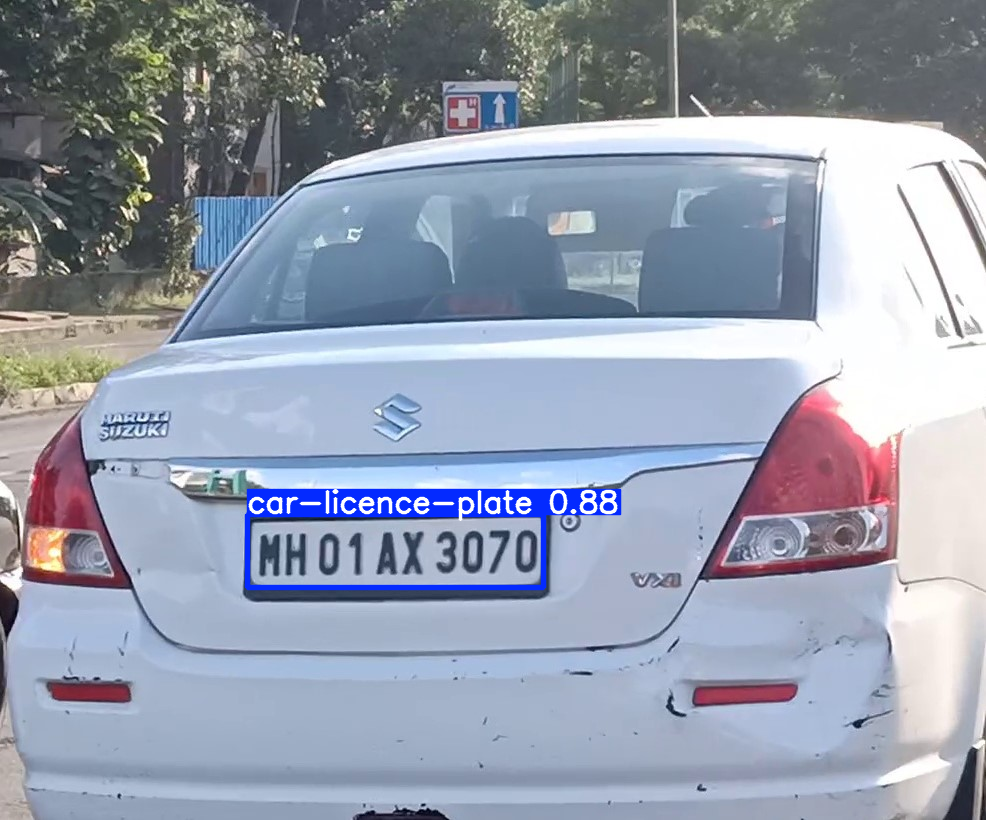

In [28]:
# Load an image or video frame (ensure it's a numpy array)
image_path = "//Users/daksh/Desktop/ANPR/datasets/video_images/video11_4650.jpg"
image = cv2.imread(image_path)

# Initialize YOLO model
model = YOLO("/Users/daksh/Desktop/ANPR/runs/detect/train/weights/best.pt")
results = model(image)

results[0].show()

Detected Number: MH 01AX 3070


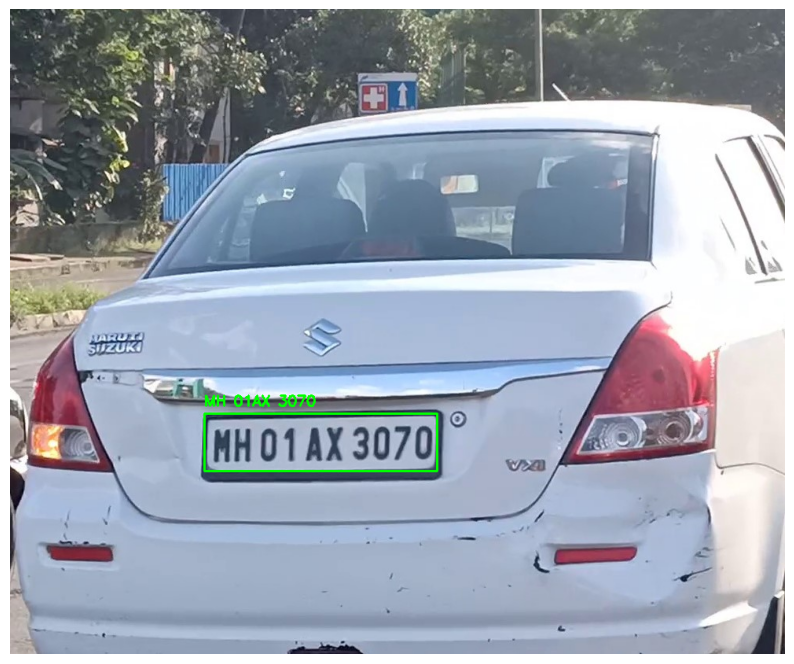

In [31]:
import easyocr

# Initialize EasyOCR Reader
reader = easyocr.Reader(['en'])  # You can specify other languages if needed

# Ensure the results output is processed as a numpy array
result_boxes = results[0].boxes.data.cpu().numpy()

# Loop through each detection
for result in result_boxes:
    x1, y1, x2, y2, confidence, class_id = result[:6]
    
    # Convert coordinates to integer for OpenCV
    x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

    # Draw the bounding box on the image
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Extract text using EasyOCR within the bounding box region
    plate_image = image[y1:y2, x1:x2]  # Crop the region containing the number plate
    result_text = reader.readtext(plate_image)  # Extract text from the cropped image

    # Check if any text was detected
    if result_text:
        # Get the first detected text (you can modify this logic if necessary)
        detected_text = result_text[0][1]  # Getting the detected text
        print(f"Detected Number: {detected_text}")

        # Display the detected text above the bounding box
        text_position = (x1, y1 - 10)  # Position text slightly above the box
        cv2.putText(image, detected_text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Convert the image from BGR to RGB format for matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Display the image with bounding boxes and text in the notebook
plt.figure(figsize=(10, 10))
plt.imshow(image_rgb)
plt.axis('off')  # Hide axes
plt.show()

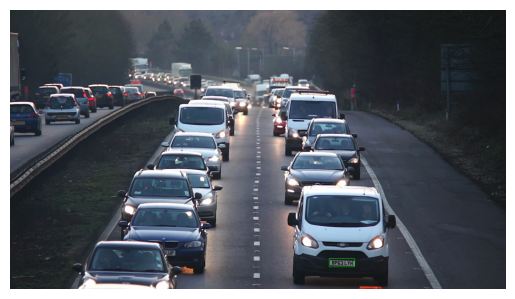

KeyboardInterrupt: 

In [37]:
import cv2
import easyocr
import pandas as pd
import re
import numpy as np
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Define the regular expression for Indian license plates
license_plate_pattern = r'^[A-Z]{2}\d{2} [A-Z]{1,2} \d{4}$'

# Create a DataFrame to store the extracted numbers
extracted_data = pd.DataFrame(columns=['Frame', 'Detected Number'])

# Video path
video_path = "/Users/daksh/Desktop/ANPR/assets/vid.mp4"


cap = cv2.VideoCapture(video_path)

frame_count = 0

while cap.isOpened():
    ret, image = cap.read()
    if not ret:
        break
    
    # Perform YOLO detection (assuming the model is trained and loaded)
    results = model.predict(image)  # Update with your model's prediction method
    # Ensure the results output is processed as a numpy array
    result_boxes = results[0].boxes.data.cpu().numpy()
    for result in result_boxes:
        x1, y1, x2, y2, confidence, class_id = result[:6]
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])

        # Draw bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        # Extract plate image for OCR
        plate_image = image[y1:y2, x1:x2]
        result_text = reader.readtext(plate_image)

        if result_text:
            detected_text = result_text[0][1].strip()
            # Validate against Indian license plate pattern
            if re.match(license_plate_pattern, detected_text):
                text_position = (x1, y1 - 10)
                cv2.putText(image, detected_text, text_position, cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                # Append to DataFrame
                extracted_data = extracted_data.append({'Frame': frame_count, 'Detected Number': detected_text}, ignore_index=True)
            else:
                print(f"Invalid number plate detected: {detected_text}")

    # Convert image to RGB for displaying in Jupyter
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Clear previous output in Jupyter notebook
    clear_output(wait=True)
    
    # Display the image with bounding boxes and detected text using matplotlib
    plt.imshow(image_rgb)
    plt.axis('off')  # Turn off axis numbers and ticks
    plt.show()
    
    # Increment frame count
    frame_count += 1

    # Exit on 'q' key
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

# Save extracted data to CSV
extracted_data.to_csv('detected_license_plates.csv', index=False)
print("Detected numbers saved to 'detected_license_plates.csv'")